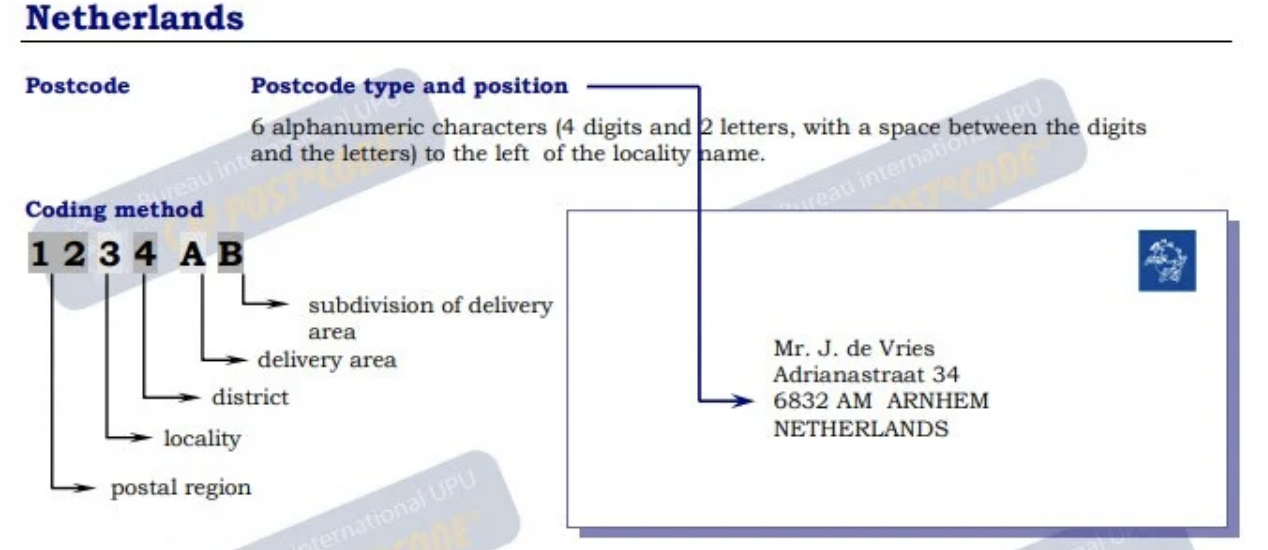

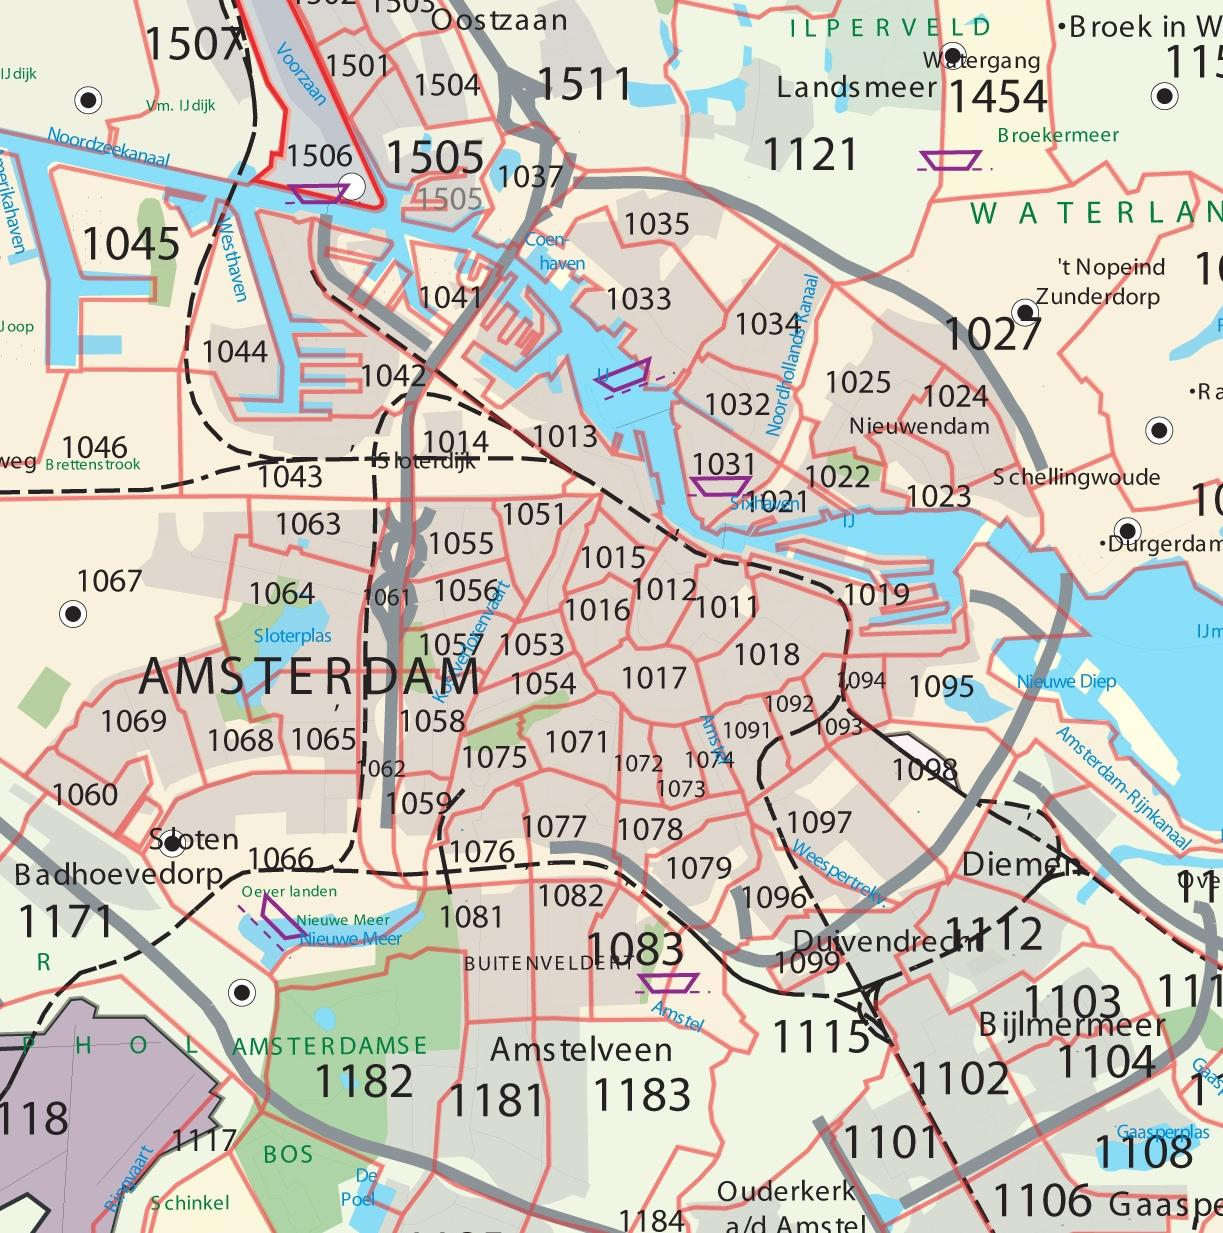

### Импорт библиотек

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# карта
import folium
from folium.plugins import MarkerCluster
from branca.colormap import LinearColormap

### Загрузка данных

In [2]:
data = pd.read_csv('/Users/pavelspirin/ODS/Tg_bot/Amsterdam_bot/HousingPrices-Amsterdam-August-2021.csv', thousands=r',',index_col=0)

### Общий анализ

In [3]:
data

,Address,Zip,Price,Area,Room,Lon,Lat
1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538
...,...,...,...,...,...,...,...
920,"Ringdijk, Amsterdam",1097 AE,750000.0,117,1,4.927757,52.354173
921,"Kleine Beerstraat 31, Amsterdam",1033 CP,350000.0,72,3,4.890612,52.414587
922,"Stuyvesantstraat 33 II, Amsterdam",1058 AK,350000.0,51,3,4.856935,52.363256
923,"John Blankensteinstraat 51, Amsterdam",1095 MB,599000.0,113,4,4.965731,52.375268


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.8+ KB


In [5]:
# проверим пропущенные значения по признакам
columns = data.columns

for col in columns:
    temp = data[col].isnull().values.sum()
    print(f'Признак {col} имеет {temp} пропущенных значения')

Признак Address имеет 0 пропущенных значения
Признак Zip имеет 0 пропущенных значения
Признак Price имеет 4 пропущенных значения
Признак Area имеет 0 пропущенных значения
Признак Room имеет 0 пропущенных значения
Признак Lon имеет 0 пропущенных значения
Признак Lat имеет 0 пропущенных значения


Имеем 924 записи в датасете, 7 признаков (адрес, зип-код, цена, площадь, количество комнат и два признака с координатами). Присутствуют 4 пропущенных значения в признаке Price. В иследовательскоим анализе удалим эти записи.

### Исследовательский анализ

In [6]:
# Удалим записи с неизвестной ценой, так как мы не сможем корректно восстановить целевой признак
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  920 non-null    object 
 1   Zip      920 non-null    object 
 2   Price    920 non-null    float64
 3   Area     920 non-null    int64  
 4   Room     920 non-null    int64  
 5   Lon      920 non-null    float64
 6   Lat      920 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.5+ KB


Напишем две функции для построения гистограммы распределения признака и диаграммы размаха

In [7]:
def plot_distribution(data, feature, bins=100):
    """
    Функция для построения гистограммы распределения признака.

    Parameters:
        data (DataFrame): DataFrame, содержащий данные.
        feature (str): Название признака для построения гистограммы.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True, bins=bins, color='skyblue')
    plt.title(f'Distribution of {feature}s')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [8]:
def plot_boxplot(data, feature):
    """
    Функция для построения диаграммы размаха признака.

    Parameters:
        data (DataFrame): DataFrame, содержащий данные.
        feature (str): Название признака для построения boxplot.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[feature], color='skyblue')
    plt.title(f'Boxplot of {feature}s')
    plt.xlabel(feature)
    plt.show()

#### Исследуем признак Price

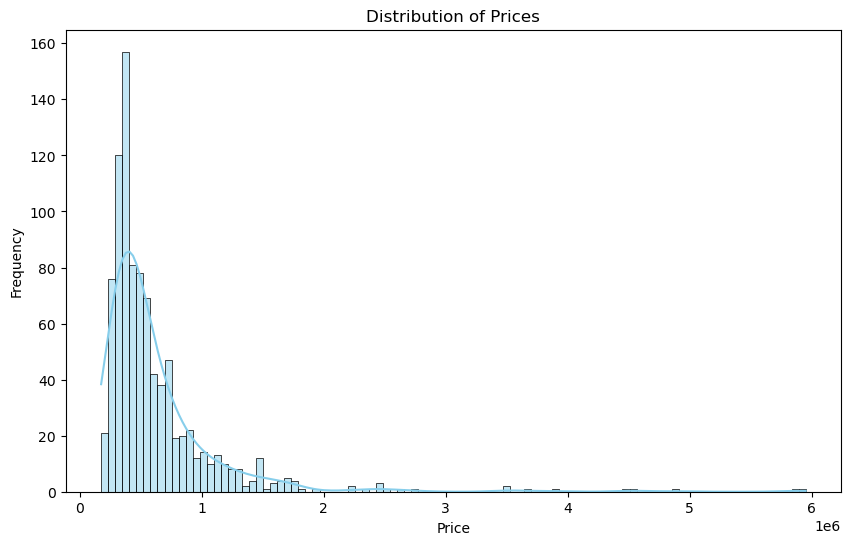

In [9]:
plot_distribution(data, 'Price')

График цены имеет нормальное распределение. В среднем почти любую квартиру можно купить до 1 млн Евро.

In [10]:
data.Price.describe()

count    9.200000e+02
mean     6.220654e+05
std      5.389942e+05
min      1.750000e+05
25%      3.500000e+05
50%      4.670000e+05
75%      7.000000e+05
max      5.950000e+06
Name: Price, dtype: float64

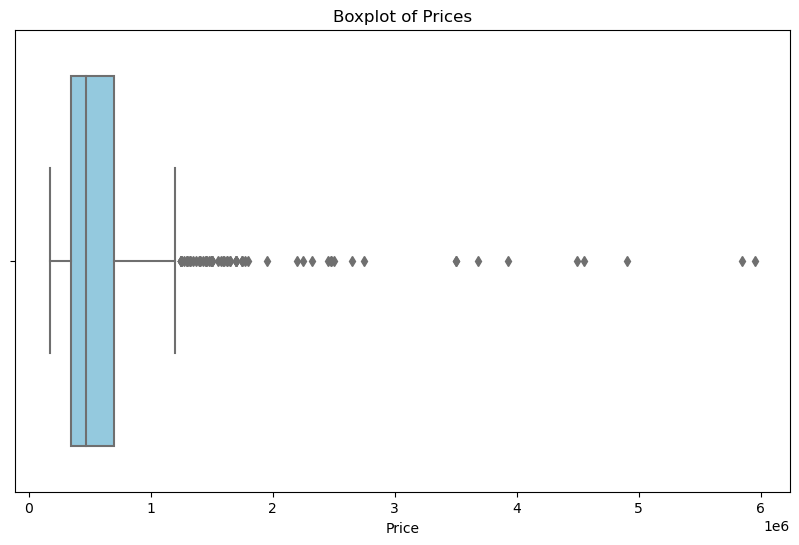

In [11]:
plot_boxplot(data, 'Price')

Диаграмма размаха показывает медиану 467к Евро. 50% всех значений лежит в диапазоне от 350к до 700к Евро. Края статистически значимой выборки равны примерно 100к - 1,2кк Евро. Так же есть выбросы вплоть до 6 млн Евро, но скорей всего это просто дорогие квартиры.

#### Исследуем признак Area

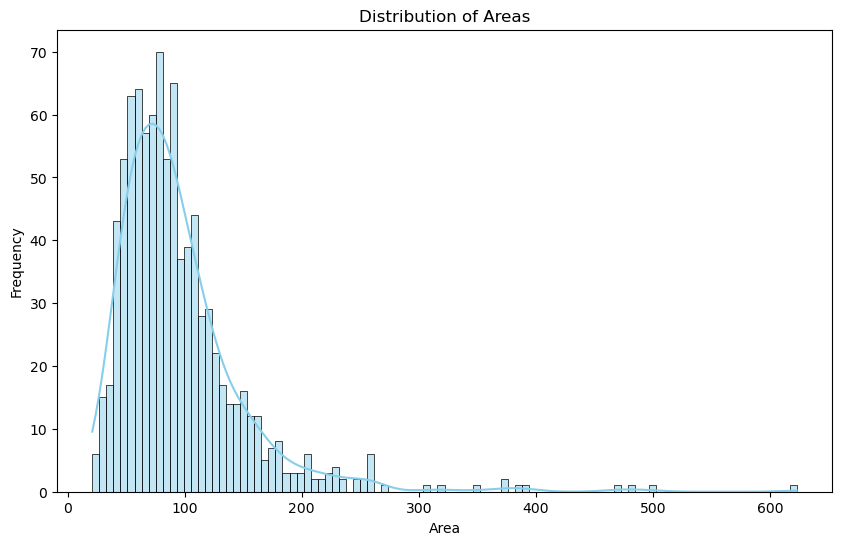

In [12]:
plot_distribution(data, 'Area')

График имеет нормальное распределение. В среднем квартиры начинаются от площади 30-40 метров квадратных и до 150 метров.

In [13]:
data.Area.describe()

count    920.000000
mean      95.607609
std       56.849699
min       21.000000
25%       60.000000
50%       83.000000
75%      113.000000
max      623.000000
Name: Area, dtype: float64

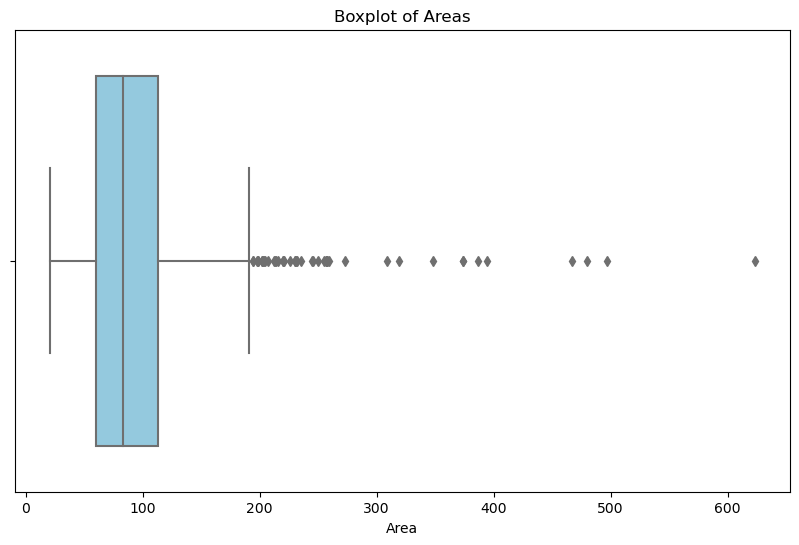

In [14]:
plot_boxplot(data, 'Area')

50% квартир имеют площадь от 60 до 113 метров квадратных (первый и третий квартили), края статистически значимой выборки равны примерно 21 - 190 метров квадратных, медиана равна 83 метра, а средняя цена 95,6 метра. Это моежт значить, что есть значительные выбросы в большую сторону (что как раз мы наблюдаем на диаграмме размаха).

#### Исследуем признак Room

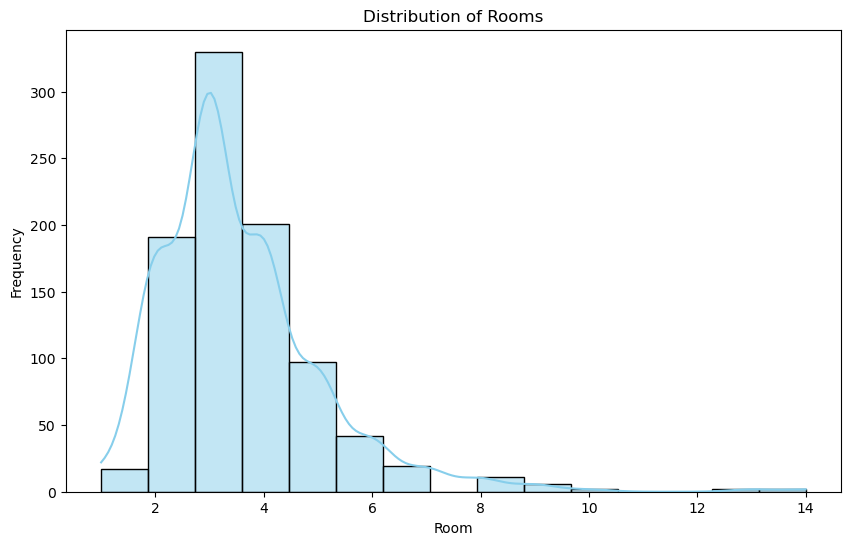

In [15]:
plot_distribution(data, 'Room', bins=15)

In [16]:
data.Room.describe()

count    920.00000
mean       3.56413
std        1.57103
min        1.00000
25%        3.00000
50%        3.00000
75%        4.00000
max       14.00000
Name: Room, dtype: float64

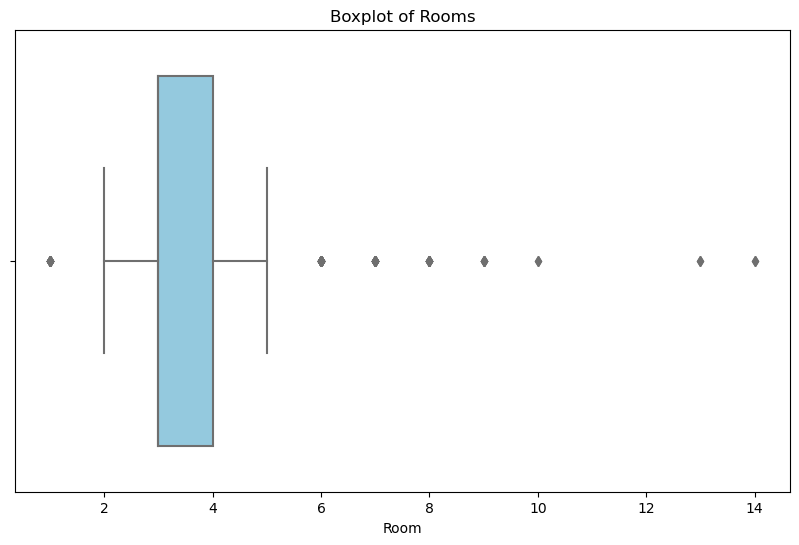

In [17]:
plot_boxplot(data, 'Room')

Диаграмма размаха говорит, что 50% квартир имеют 3-4 комнаты, а края статистически значимой выборки равны 2-5 комнат. Медиана равна 3 комнатам, а среднее значений - 3.56, что опять говорит о выбросах в большую сторону. В выборке есть квартиры с 14 комнатами.

### Анализ геоположения

Построим расположение квартир на карте Амстердама, а так же построим "тепловую" карту в зависимости от цен, чтобы увидеть районы с дешевой/дорогой/элитной недвижимостью

In [18]:
def plot_apartments_on_map(data, latitude_col, longitude_col):
    """
    Функция для отображения квартир на карте.

    Parameters:
        data (DataFrame): DataFrame, содержащий данные.
        latitude_col (str): Название столбца с широтой.
        longitude_col (str): Название столбца с долготой.
    """
    # Создаем карту
    m = folium.Map(location=[data[latitude_col].mean(), data[longitude_col].mean()], zoom_start=12)

    # Добавляем маркеры для каждой квартиры
    for index, row in data.iterrows():
        folium.Marker([row[latitude_col], row[longitude_col]], 
                      popup=f"{row['Address']}\nPrice: {row['Price']}").add_to(m)

    # Отображаем карту
    display(m)

In [19]:
plot_apartments_on_map(data, "Lat", "Lon")

In [20]:
def plot_colored_apartments_on_map(data, latitude_col, longitude_col, price_col):
    """
    Функция для отображения квартир на карте с цветовой кодировкой в зависимости от цены.

    Parameters:
        data (DataFrame): DataFrame, содержащий данные.
        latitude_col (str): Название столбца с широтой.
        longitude_col (str): Название столбца с долготой.
        price_col (str): Название столбца с ценой квартиры.
    """
    # Настраиваем цветовую карту с указанными интервалами и ограничением до 1 млн
    colormap = LinearColormap(['white', 'lightgreen', 'green', 'yellow', 'orange', 'red', 'brown'], 
                              index=[0, 150000, 300000, 450000, 600000, 750000, 1000000],
                              vmin=data[price_col].min(), 
                              vmax=1000000)

    # Создаем карту
    m = folium.Map(location=[data[latitude_col].mean(), data[longitude_col].mean()], zoom_start=12)

    # Создаем кластер маркеров для более удобного отображения на карте
    marker_cluster = MarkerCluster().add_to(m)

    # Добавляем маркеры для каждой квартиры
    for index, row in data.iterrows():
        # Получаем цвет для текущей цены
        color = colormap(row[price_col])

        # Добавляем круглый маркер в кластер
        folium.CircleMarker([row[latitude_col], row[longitude_col]], 
                            radius=5,
                            color=color,
                            fill=True,
                            fill_color=color,
                            fill_opacity=0.7,
                            popup=f"{row['Address']}\nPrice: {row[price_col]}").add_to(marker_cluster)

    # Добавляем цветовую карту в легенду
    colormap.add_to(m)

    display(m)

In [21]:
plot_colored_apartments_on_map(data, "Lat", "Lon", "Price")

На картах видим, что у нас есть разделение квартир по ценам, а следовательно, мы теперь знаем распределение цен по районам. Из этого можно заключить, что мы сможем добавить новый признак в наш датасет с названиями районов, что в будущем будет одним из трех основных призаков, по которым пользователь сможет узнать цену квартиры. 

У нас есть признак Zip (четыре цифры + две буквы), в котором первые две цифры - это почтовый регион, третья - цифра местность, четвертая цифра - район, а две буквы означают район доставки и подразделение района доставки соотвественно. 

Из этого следует, что нам важны только 4 цифры почтового индекса. По ним пользователь и будет определять более точное расположение недвижимости.

In [22]:
data['District'] = data['Zip'].str[:4]
data.head()

,Address,Zip,Price,Area,Room,Lon,Lat,District
1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157,1091
2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586,1059
3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782,1097
4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712,1060
5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538,1036


In [23]:
data.District.nunique()

70

Теперь мы можем посмотреть среднюю цену по районам, определим корреляцию между всеми интересующими нас признаками (Price, Area, Room, District). Имеено по этим признакам пользователь будет определять цену недвижимости. Другие признаки, а именно Address, Zip, Lon и Lat следует удалить из датасета

In [24]:
final_data = data.drop(['Address', 'Zip', 'Lon', 'Lat'], axis=1)
final_data.head()

,Price,Area,Room,District
1,685000.0,64,3,1091
2,475000.0,60,3,1059
3,850000.0,109,4,1097
4,580000.0,128,6,1060
5,720000.0,138,5,1036


In [68]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 920 entries, 1 to 924
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     920 non-null    float64
 1   Area      920 non-null    int64  
 2   Room      920 non-null    int64  
 3   District  920 non-null    object 
dtypes: float64(1), int64(2), object(1)
memory usage: 35.9+ KB


Изменим типы данных на int32. Этот тип данных использует 32 бита и может представлять целые числа от -2,147,483,648 до 2,147,483,647. Что нам вполне хватит чтобы задействовать весь диапазон цен и сократить вычислительную память.

In [27]:
final_data[['Price', 'Area', 'Room', 'District']] = final_data[['Price', 'Area', 'Room', 'District']].astype('int32')

In [28]:
final_data.dtypes

Price       int32
Area        int32
Room        int32
District    int32
dtype: object

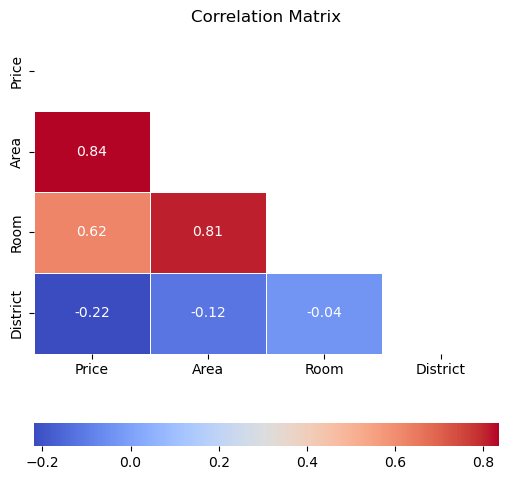

In [37]:
# Создание матрицы корреляций
correlation_matrix = final_data.corr()

# Генерация маски для верхней правой части
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Построение тепловой карты
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask, cbar_kws={"orientation": "horizontal"})
plt.title('Correlation Matrix')

# Скрытие верхней правой оси
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Есть довольно сильная корреляция между ценой и площадью, а так же между площадью и количеством комнат.

Посмотри на 10 самых дорогих и самых дешевых района по средней цене. Данная информация будет так же полезна конечному пользователю, для более оптимальной навигации по карте

In [46]:
# Группировка по районам и вычисление средней цены
result = final_data.groupby('District')['Price'].mean().sort_values(ascending=False)

# Вывод 10 самых дорогих районов
print('Топ 10 самых дорогих районов:')
for district, mean_price in result.head(10).items():
    min_price = final_data[final_data['District'] == district]['Price'].min()
    max_price = final_data[final_data['District'] == district]['Price'].max()
    print(f'Район {district}: от {min_price} до {max_price}, средняя цена {mean_price:.2f}')

# Вывод 10 самых дешевых районов
print('\nТоп 10 самых дешевых районов:')
for district, mean_price in result.tail(10).items():
    min_price = final_data[final_data['District'] == district]['Price'].min()
    max_price = final_data[final_data['District'] == district]['Price'].max()
    print(f'Район {district}: от {min_price} до {max_price}, средняя цена {mean_price:.2f}')

Топ 10 самых дорогих районов:
Район 1075: от 345000 до 5850000, средняя цена 1509653.85
Район 1031: от 549000 до 3680000, средняя цена 1395600.00
Район 1017: от 295000 до 5950000, средняя цена 1259000.00
Район 1071: от 550000 до 2500000, средняя цена 1256500.00
Район 1016: от 395000 до 4900000, средняя цена 1168631.58
Район 1028: от 700000 до 1495000, средняя цена 1097500.00
Район 1012: от 340000 до 4495000, средняя цена 1093533.33
Район 1027: от 765000 до 1695000, средняя цена 1067000.00
Район 1077: от 425000 до 1700000, средняя цена 982000.00
Район 1014: от 475000 до 1450000, средняя цена 963000.00

Топ 10 самых дешевых районов:
Район 1034: от 300000 до 515000, средняя цена 376538.46
Район 1104: от 250000 до 600000, средняя цена 350009.79
Район 1068: от 250000 до 550000, средняя цена 348019.23
Район 1024: от 250000 до 799000, средняя цена 335200.00
Район 1063: от 200000 до 500000, средняя цена 331785.71
Район 1108: от 300000 до 350000, средняя цена 325000.00
Район 1106: от 209000 до 

### Machine Learning

В данном разделе мы:
- Разделим датасет на выборки
- Проведем масштабирование и категоризацию признаков
- Создадим функцию оценки качества модели (метрика)
- Построим три модели и определим лучшую
- Протестируем ее на тестовых данных
- Сравним с константной моделью
- Найдем важность признаков

In [ ]:
# создадим функцию для необходимого скора
def mae_score (target, predictions):
    mae = mean_absolute_error(target, predictions)
    return mae
scorer = make_scorer(mae_score, greater_is_better=False)